In [2]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import re
import torch
import ast
from sklearn.model_selection import train_test_split

import albumentations as A

from torch.utils.data import Dataset, DataLoader

from PIL import Image
import pickle


In [29]:
df = pd.read_csv("ODIR-5K_Training_Preprocessed.csv")

df = df[['ID', 'labels']]
df['labels'] = df['labels'].apply(lambda x: ast.literal_eval(x))
dfdummy = pd.get_dummies(df['labels'].apply(pd.Series).stack()).sum(level=0)
df = pd.concat([df, dfdummy], axis=1)

/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_28423/1634764361.py:5: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dfdummy = pd.get_dummies(df['labels'].apply(pd.Series).stack()).sum(level=0)


In [30]:
# Change every item in labels to classes from 0 to 7
df['labels'] = df['labels'].apply(lambda x: [0 if i == 'A' else 1 if i == 'C' else 2 if i == 'D' else 3 if i == 'G' else 4 if i == 'H' else 5 if i == 'M' else 6 if i == 'N' else 7 for i in x])

# Convert the labels from A, C,D, G, H, M, n and O to a column of lists
df['coded labels'] = df.apply(lambda x: [x['A'], x['C'], x['D'], x['G'], x['H'], x['M'], x['N'], x['O']], axis=1)

df['Name'] = df['ID'].apply(lambda x: os.path.splitext(x)[0])
df['Name'] = df['Name'].str.cat(df['coded labels'].astype(str), sep ="_")

df

,ID,labels,A,C,D,G,H,M,N,O,coded labels,Name
0,0_left.jpg,[1],0,1,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0]","0_left_[0, 1, 0, 0, 0, 0, 0, 0]"
1,0_right.jpg,[6],0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 1, 0]","0_right_[0, 0, 0, 0, 0, 0, 1, 0]"
2,1_left.jpg,[6],0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 1, 0]","1_left_[0, 0, 0, 0, 0, 0, 1, 0]"
3,1_right.jpg,[6],0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 1, 0]","1_right_[0, 0, 0, 0, 0, 0, 1, 0]"
4,2_left.jpg,"[2, 7]",0,0,1,0,0,0,0,1,"[0, 0, 1, 0, 0, 0, 0, 1]","2_left_[0, 0, 1, 0, 0, 0, 0, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...
6563,4689_right.jpg,[6],0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 1, 0]","4689_right_[0, 0, 0, 0, 0, 0, 1, 0]"
6564,4690_left.jpg,[2],0,0,1,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0]","4690_left_[0, 0, 1, 0, 0, 0, 0, 0]"
6565,4690_right.jpg,[2],0,0,1,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0]","4690_right_[0, 0, 1, 0, 0, 0, 0, 0]"
6566,4784_left.jpg,"[0, 4]",1,0,0,0,1,0,0,0,"[1, 0, 0, 0, 1, 0, 0, 0]","4784_left_[1, 0, 0, 0, 1, 0, 0, 0]"


In [5]:
output_path = "./squared_and_cropped_dataset/"

In [6]:


for item in range(len(df['ID'])):
    os.rename(output_path + df['ID'][item], output_path + df['Name'][item] + '.jpg')


KeyError: 'Name'

In [6]:
train_img = [os.path.join(output_path, i) for i in os.listdir(output_path)]

In [39]:

def createxy(image_list):
    X = []  # images
    y = []  # labels (0 for Normal or 1 for Pneumonia)
    pattern = r'\[([\d,\s]+)\]'

    for image in tqdm(image_list):
        try:
            img = cv2.imread(image)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
                img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                X.append(img)
        except:
            continue

        match = re.search(pattern, image)
        extracted_list = match.group(1).split(',')
        extracted_list = [int(i) for i in extracted_list]
        y.append(extracted_list)

    return X, y
    
X_train, y_train = createxy(train_img)

100%|██████████| 6568/6568 [00:11<00:00, 564.33it/s]


In [40]:
len(X_train)

6568

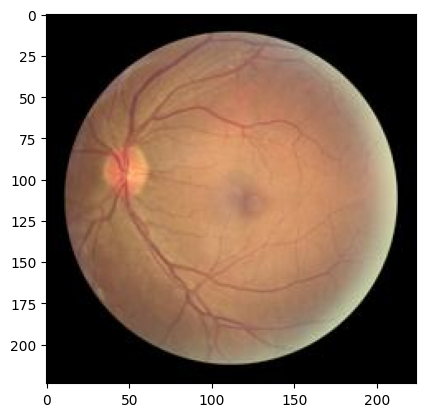

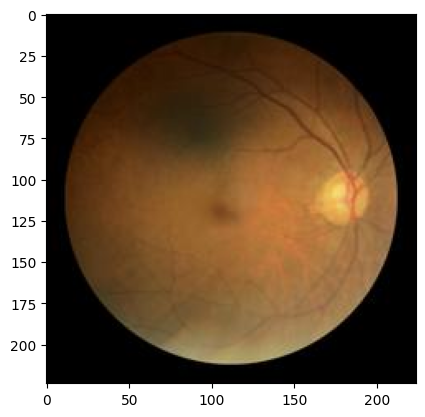

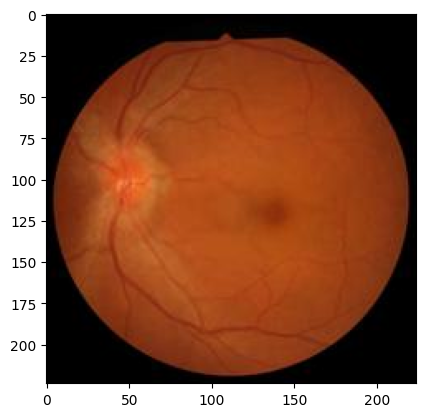

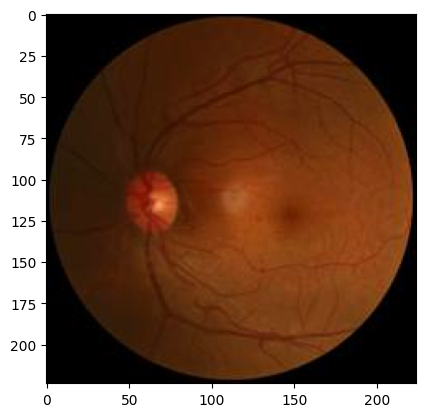

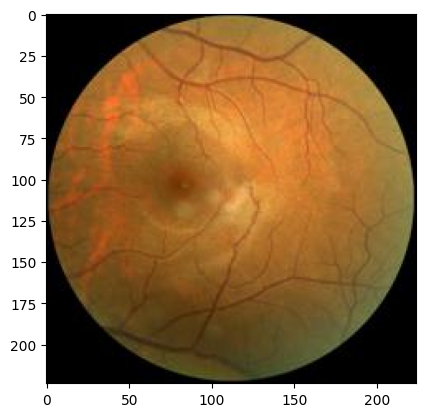

In [41]:
#plot X_train of augmented dataset
for i in range(5):
    plt.imshow(X_train[i])
    plt.show()

In [64]:
# Define your augmentations
augmentations = A.Compose([
    A.Rotate(limit=15, p=0.5),               # Random rotation up to 15 degrees
    A.HorizontalFlip(p=0.5),                # Horizontal flipping with a 50% probability
    # A.RandomBrightnessContrast(p=0.5),     # Random brightness and contrast adjustments
    # A.ElasticTransform(alpha=1, sigma=10, alpha_affine=10, p=0.5),  # Elastic deformation
    # A.Blur(blur_limit=(3, 7), p=0.5),      # Gaussian blur
    # A.RandomGamma(p=0.5),                  # Random gamma adjustment
    # A.HueSaturationValue(p=0.5),           # Hue, saturation, and value adjustments
], p=1)


def augmented_set(X_train, y_train, augmentations):
    X_train_augmented = []
    y_train_augmented = []
    for i in range(len(X_train)):
        # get image and label
        image = X_train[i]
        label = y_train[i]

        # augment image
        augmented = augmentations(image=image)
        augmented_image = augmented['image']
        
        # append image and label
        X_train_augmented.append(augmented_image)
        y_train_augmented.append(label)

    return X_train_augmented, y_train_augmented

In [65]:
num_classes = len(y_train[0])  # Get the number of classes

# Initialize lists for each class
class_X_train = [[] for _ in range(num_classes)]
class_y_train = [[] for _ in range(num_classes)]

# Loop through the data and assign each sample to the appropriate class
for i in range(len(X_train)):
    labels = y_train[i]
    for j in range(num_classes):
        if labels[j] == 1:
            class_X_train[j].append(X_train[i])
            class_y_train[j].append(labels)

In [68]:
# Initialize lists for all augmentations per class
augmented_X_train = [[] for _ in range(num_classes)]
augmented_y_train = [[] for _ in range(num_classes)]

# Loop through all classes
for i in range(num_classes):
    x = class_X_train[i]
    y = class_y_train[i]
    x_augmented, y_augmented = augmented_set(x, y, augmentations)
    x_augmented2, y_augmented2 = augmented_set(x, y, augmentations)
    t = 0
    # Append from first set of augmentations
    while len(y) < (2*len(y_augmented)):
        x.append(x_augmented[t])
        y.append(y_augmented[t])
        t += 1
    # Append from second set of augmentations
    s = 0
    while (2*len(y_augmented)) <= len(y) < (3*len(y_augmented)):
        x.append(x_augmented2[s])
        y.append(y_augmented2[s])
        s += 1
    augmented_X_train[i].append(x)
    augmented_y_train[i].append(y)

# Check class imbalance
for i in range(len(augmented_y_train)):
    print(len(augmented_y_train[i]))

1
1
1
1
1
1
1
1


In [80]:
len(augmented_X_train[2][0])

5334

In [73]:
augmented_y_train

[[[[1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 1, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 1],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 1, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0

In [55]:
X_train_augmented1, y_train_augmented1 = augmented_set(X_train, y_train, augmentations)
# X_train_augmented1, y_train_augmented2 = augmented_set(X_train, y_train, augmentations)

In [48]:
X_train1, X_validation1, y_train1, y_validation1 = train_test_split(X_train_augmented1, y_train_augmented1, test_size=(500/3500), random_state=42, shuffle=True)

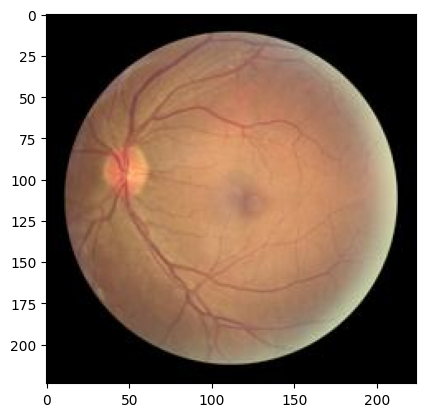

In [56]:
plt.imshow(X_train[0])
plt.show()

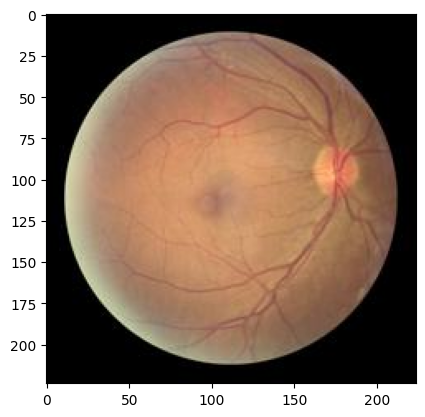

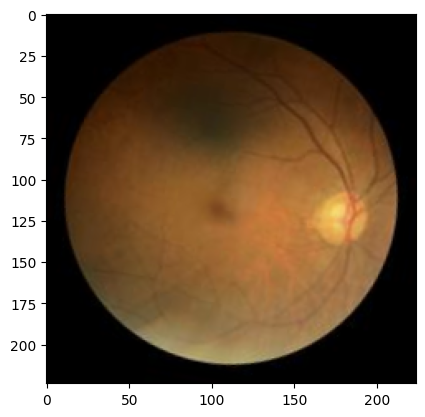

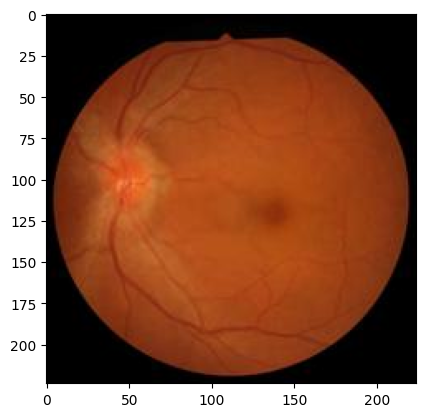

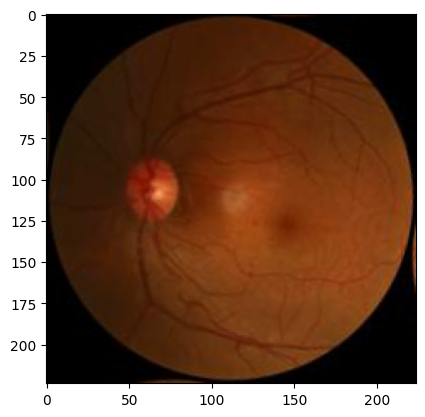

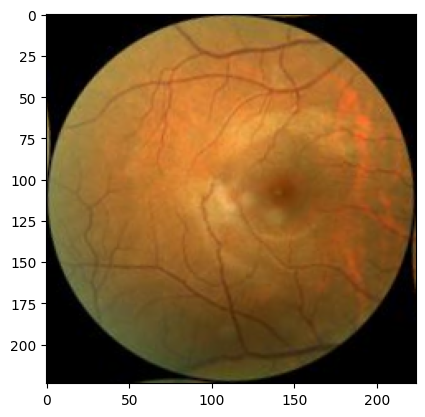

In [57]:
for i in range(5):
    plt.imshow(X_train_augmented1[i])
    plt.show()

In [36]:
print(X_train1[0].type)

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [35]:
print(X_train1[0].shape)
print(y_train1[0].shape)
print(X_validation1[0].shape)
print(y_validation1[0].shape)

(224, 224, 3)


AttributeError: 'list' object has no attribute 'shape'

In [31]:
from collections import Counter
labels_count = Counter(label for lbs in df['labels'] for label in lbs)

In [32]:
total_count = sum(labels_count.values())
class_weights = {cls: total_count / count for cls, count in labels_count.items()}

In [33]:
class_weights = dict(sorted(class_weights.items()))
class_weights

{0: 25.164285714285715,
 1: 24.46527777777778,
 2: 3.9628796400449944,
 3: 22.511182108626198,
 4: 36.50777202072539,
 5: 26.893129770992367,
 6: 2.495042492917847,
 7: 6.359205776173285}

In [33]:
with open('./Datasets/class_weights.pkl', 'wb') as file:
    pickle.dump(class_weights, file)

In [34]:
X_train = np.save('./Datasets/X_train.npy', X_train1)
y_train = np.save('./Datasets/y_train.npy', y_train1)
X_val = np.save('./Datasets/X_val.npy', X_validation1)
y_val = np.save('./Datasets/y_val.npy', y_validation1)

------------------------------ OUDE AUGMENTATIE --------------------------------

-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-

In [20]:
X_train = np.asarray(X_train_augmented1, dtype=np.float32)
y_train = np.asarray(y_train_augmented1, dtype=np.float32)

In [41]:
X_train[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [63]:

class ImageDataset(Dataset):
    def __init__(self, images, labels, transforms):
        self.X = images
        self.y = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        transformed = self.transforms(image=self.X[index])
        transformed_image = transformed["image"]
        transformed_image = transformed_image.transpose((2, 0, 1))
        target = self.y[index]
        target = np.expand_dims(target, axis=0)
        target = torch.from_numpy(target).float()

        return transformed_image, target

augmentations = A.Compose([
        A.Rotate(limit=15, p=0.5),  # Random rotation up to 15 degrees
        A.HorizontalFlip(p=0.5),   # Horizontal flipping with a 50% probability
        A.RandomBrightnessContrast(p=0.5),  # Random brightness and contrast adjustments
        A.ElasticTransform(alpha=1, sigma=10, alpha_affine=10, p=0.5),  # Elastic deformation
        A.Blur(blur_limit=(3, 7), p=0.5),  # Gaussian blur
        A.RandomGamma(p=0.5),  # Random gamma adjustment
        A.HueSaturationValue(p=0.5),  # Hue, saturation, and value adjustments
    ], p=1)

augmented_dataset1 = ImageDataset(X_train, y_train, augmentations)
augmented_dataloader1 = DataLoader(augmented_dataset1, batch_size=1, shuffle=True)

augmented_dataset2 = ImageDataset(X_train, y_train, augmentations)
augmented_dataloader2 = DataLoader(augmented_dataset2, batch_size=1, shuffle=True)

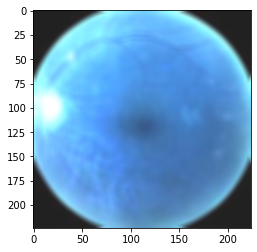

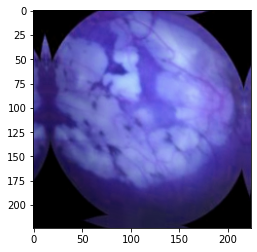

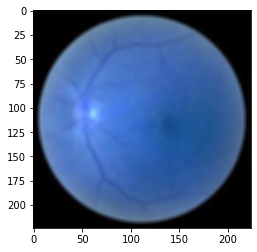

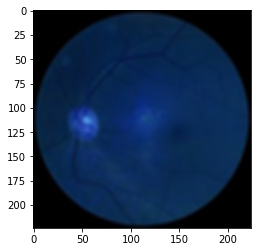

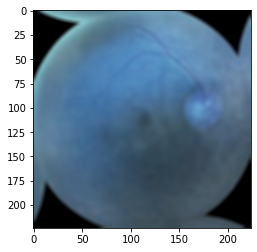

In [68]:
#plot X_train of augmented dataset
for i in range(5):
    image, target = next(iter(augmented_dataloader1))
    image = image.squeeze(0)
    image = image.numpy()
    image = image.transpose((1, 2, 0))
    plt.imshow(image)
    plt.show()

In [58]:
#fix class imbalance
len(augmented_dataset)

6568

In [ ]:
#split into train and validation sets